In [33]:
!pip install torchextractor

In [34]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image

In [35]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

not_beard_path = oj(data_path, "processed", "no_beard_224")
beard_path = oj(data_path, "processed", "beard_224")

In [37]:
import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)

model = models.resnet18(pretrained=True)

# Modify the classifier (replace the last fully connected layer) it is called fc for resnet18
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
params_to_update = model.fc.parameters()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
def clean_up_empty_files(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        if os.path.getsize(oj(path, list_files[i])) < 100:
            os.remove(oj(path, list_files[i]))
            print("File " + str(i) + "deleted!")
'''
def clean_up_duplicates(path1, path2):
    newfiles = os.listdir(path1)
    oldfiles = os.listdir(path2)
    diff = [f for f in newfiles if f not in oldfiles]
    for i in tqdm(diff):
        os.remove(oj(path1, i))
        print("File " + str(i) + "deleted!")

def check_img_sizes(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        im = Image.open(oj(path, list_files[i]))
        if im.width != 224 or im.height != 224:
            print(list_files[i])
'''
# clean_up_empty_files(cancer_path)
# clean_up_empty_files(not_cancer_path)

# newpath = oj(data_path, "no_cancer_224_inpainted")
# oldpath = oj(data_path, "processed", "no_cancer_224")
# clean_up_duplicates(newpath, oldpath)

# check_img_sizes(not_cancer_path)


'\ndef clean_up_duplicates(path1, path2):\n    newfiles = os.listdir(path1)\n    oldfiles = os.listdir(path2)\n    diff = [f for f in newfiles if f not in oldfiles]\n    for i in tqdm(diff):\n        os.remove(oj(path1, i))\n        print("File " + str(i) + "deleted!")\n\ndef check_img_sizes(path):\n    list_files= os.listdir(path)\n    num_files = len(list_files)\n    for i in tqdm(range(num_files)):\n        im = Image.open(oj(path, list_files[i]))\n        if im.width != 224 or im.height != 224:\n            print(list_files[i])\n'

In [39]:
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, path: str = None, is_beard: int = None, data_files = None, labels = None):
        """
        Expects path and is_beard both to be supplied if the relevant images all lie in the same directory and have the same class
        or a list of full filepaths and list of all labels are both supplied using data_files and labels otherwise.
        """

        """
        Initializes the WaterbirdDataset.

        If 'path' and 'is_beard' are provided, it assumes that all images in the directory specified
        by 'path' belong to the same class 'is_beard'.

        Alternatively, if 'data_files' and 'labels' are provided, it uses these lists directly
        for file paths and corresponding labels.

        Args:
            path (str): Directory containing images, all belonging to the same class.
            is_beard (int): The class label (e.g., 1 for waterbird, 0 for non-waterbird) for all images in the directory.
            data_files (list): List of full file paths to images.
            labels (list): List of labels corresponding to 'data_files'.
        """
        if path: # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_beard = is_beard

        else: # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.is_beard = None

    def __getitem__(self, i):

        """
        Retrieves an image and its label at index 'i'.

        Args:
            i (int): Index of the image to retrieve.

        Returns:
            tuple: (image tensor, label)
        """


        # Read in the image, convert to float between [0,1] and standardise , and convert to a PyTorch tensor
        img = Image.open(oj(self.path, self.data_files[i]))
        img_array = np.asarray(img)/255.0 # Convert image to float and scale to [0, 1]
        img_array -= mean[None, None, :] # Subtract the mean for normalization
        img_array /= std[None, None, :] # Divide by the standard deviation for normalization
        img.close()
        torch_img = torch.from_numpy(img_array.swapaxes(0,2).swapaxes(1,2)).float() # Convert the numpy array to a PyTorch tensor and rearrange the axes
        # Determine the label: use the global class label if provided, otherwise extract the relevant label from the list of labels.
        is_beard = self.is_beard if self.is_beard is not None else self.labels[i]
        return (torch_img, is_beard)

    def __len__(self): # Returns the total number of images in the dataset.
        return len(self.data_files)

## Functions for Training

In [40]:
def gradient_sum(im, target, model, crit, device='cuda'):
    '''assume that eveything is already on cuda'''
    im.requires_grad = True # Enable gradient computation for the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im,create_graph = True)[0].sum(dim=1)).sum()
    return grad_params

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, resume_training=False):
    since = time.time()
    # train_loss_history = []
    # train_acc_history = []
    # train_cd_history= []


    # Initialize best_loss, patience, and cur_patience to manage early stopping.
    best_loss = 10.0
    patience = 3 # Number of epochs to wait for improvement
    cur_patience = 0 # Current patience counter

    if len(os.listdir(model_training_path)) > 0 and resume_training:
      # Check if there are saved model files and resume training if needed
        model_list = [(f, os.path.getmtime(oj(model_training_path,f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)  # Sort models by modification time in place from most to least recent
        model_name = model_list[0][0]
        model.fc.load_state_dict(torch.load(oj(model_training_path, model_name)))
        print("Model loaded!")

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        optimizer.step() # Update the model parameters
        model.train()  # Set model to training mode
        phase = 'train'
        running_loss = 0.0
        running_loss_cd = 0.0
        running_corrects = 0

        # Iterate over data , moving inputs and labels to the specified device.
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase])):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # need to do calc beforehand because we do need the gradients
                if phase == 'train' and regularizer_rate !=0:
                  # Apply gradient regularization if specified , compute additional loss from gradients and update the model.
                    inputs.requires_grad = True
                    add_loss = gradient_sum(inputs, labels, model, criterion)
                    if add_loss!=0:
                        (regularizer_rate*add_loss).backward()
                        optimizer.step()
                    #print(torch.cuda.memory_allocated()/(np.power(10,9)))
                    optimizer.zero_grad()
                    running_loss_cd += add_loss.item() * inputs.size(0)

                    #inputs.require_grad = False

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    (loss).backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_cd_loss = running_loss_cd / dataset_sizes[phase]

        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f} CD Loss : {:.4f}'.format(
            phase, epoch_loss, epoch_acc, epoch_cd_loss))

        # train_loss_history.append(epoch_loss)
        # train_cd_history.append(epoch_cd_loss)
        # train_acc_history.append(epoch_acc.item())
        torch.save(model.fc.state_dict(), oj(model_training_path, datetime.now().strftime("%Y%m%d%H%M%S") + ".pt"))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60)
    )
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    return model

## Functions for Evaluation

In [41]:
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score

def get_output(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=False, num_workers=2)
    model = model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax() #Creates a Softmax function to convert logits to probabilities.
    with torch.no_grad() : # Disables gradient computation for the operations within this block, saving memory and computation.

        # Iterate over the DataLoader, moves inputs to GPU, and appends true labels and predicted probabilities to their respective lists.
        for inputs, labels in data_loader:
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,1].detach().cpu().numpy()) # take the probability for beard
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return y, y_hat # in the training set the values were switched

def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys(): #for the gradient models we unfortunately saved all of the weights
            model.load_state_dict(weights)
        else:
            model.fc.load_state_dict(weights)
        y, y_hat = get_output(model.fc, dataset)
    else:
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

## Initial Classifier Training (on waterbirds no patch and not waterbirds with & without patch)

In [42]:
beard_no_patch_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_nopatch_224"

In [43]:
beard_no_patch_dataset = CelebADataset(path=beard_no_patch_path, is_beard=1)
not_beard_dataset = CelebADataset(path=not_beard_path, is_beard=0)
complete_dataset = ConcatDataset((beard_no_patch_dataset, not_beard_dataset))

num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
torch.manual_seed(0);
print("num_train:", num_train)
print("num_test:", num_test)

train_dataset, test_dataset = torch.utils.data.random_split(complete_dataset, [num_train, num_test])
datasets = {'train' : train_dataset, 'test':test_dataset}
dataset_sizes = {'train' : len(train_dataset), 'test':len(test_dataset)}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

num_train: 3012
num_test: 754


In [44]:
def list_to_file(li, filename):
  with open(filename, 'w') as f:
    for item in li:
      f.write("%s\n" % item)

def extract_filenames(train_subset, test_subset):
  # Extract the relevant indices of the concat dataset
  train_idx, test_idx = train_subset.indices, test_subset.indices

  # Extract the filenames for the beard_dataset and not_beard_dataset and concatenate with their directory path.
  # Each original dataset is stored by the ConcatDataset class. So even though train_subset is a subset, the info for the whole beard dataset is stored in train_subset.dataset.datasets[0]
  beard_no_patch_filepaths      = [oj(train_subset.dataset.datasets[0].path, file) for file in train_subset.dataset.datasets[0].data_files]
  not_beard_filepaths  = [oj(train_subset.dataset.datasets[1].path, file) for file in train_subset.dataset.datasets[1].data_files]

  filepaths = beard_no_patch_filepaths + not_beard_filepaths    # Append the lists together, this combined list is what the indices are based on.

  train_files = [filepaths[i] for i in train_idx]
  test_files  = [filepaths[i] for i in test_idx]

  return train_files, test_files

In [45]:
# Call the function and get the full file paths.
train_files, test_files = extract_filenames(train_dataset, test_dataset)
list_to_file(train_files, oj(dir_path, 'models', 'train_files.txt'))   # Write the training filepaths to a text file.
list_to_file(test_files,  oj(dir_path, 'models', 'test_files.txt'))    # Write the testing filepaths to a text file.

## Weights for Training

In [46]:
beard_ratio = len(beard_no_patch_dataset)/len(complete_dataset)

not_beard_ratio = 1 - beard_ratio
beard_weight = 1/beard_ratio
not_beard_weight = 1/ not_beard_ratio
weights = np.asarray([not_beard_weight, beard_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [47]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.fc.state_dict(),oj(dir_path, model_path, pid + ".pt"))

Epoch 1/10
----------


189it [00:27,  6.86it/s]


train Loss: 0.7062 Acc: 0.5667 CD Loss : 0.0000
Epoch 2/10
----------


189it [00:26,  7.01it/s]

train Loss: 0.6623 Acc: 0.7022 CD Loss : 0.0000
Epoch 3/10
----------



189it [00:17, 11.09it/s]

train Loss: 0.6410 Acc: 0.7341 CD Loss : 0.0000
Epoch 4/10
----------



189it [00:17, 10.92it/s]

train Loss: 0.6197 Acc: 0.7264 CD Loss : 0.0000
Epoch 5/10
----------



189it [00:17, 10.79it/s]

train Loss: 0.6036 Acc: 0.7480 CD Loss : 0.0000
Epoch 6/10
----------



189it [00:17, 10.53it/s]

train Loss: 0.5849 Acc: 0.7493 CD Loss : 0.0000
Epoch 7/10
----------



189it [00:18, 10.41it/s]

train Loss: 0.5767 Acc: 0.7450 CD Loss : 0.0000
Epoch 8/10
----------



189it [00:16, 11.25it/s]

train Loss: 0.5614 Acc: 0.7673 CD Loss : 0.0000
Epoch 9/10
----------



189it [00:16, 11.22it/s]

train Loss: 0.5542 Acc: 0.7782 CD Loss : 0.0000
Epoch 10/10
----------



189it [00:16, 11.16it/s]

train Loss: 0.5418 Acc: 0.7583 CD Loss : 0.0000
Training complete in 3m 14s
Best val loss: 10.000000


In [49]:
auc, f1 = get_auc_f1(model, test_dataset)
print("AUC: ", auc)
print("F1: ", f1)

AUC:  0.8244364235055724
F1:  0.4444444444444444


In [50]:
results_file_path = oj(dir_path, "auc_f1_224_resnet18_beard_no_patch.txt")
print(results_file_path)
with open(results_file_path, 'w') as f:
    f.write('AUC: ' + str(auc) + "\n")
    f.write('F1: ' + str(f1) + "\n")

/content/drive/MyDrive/Masterthesis/Datasets/CelebA/auc_f1_224_resnet18_beard_no_patch.txt


## Reload the model to skip retrainig and test with waterbird patched images

In [51]:
beard_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224'
not_beard_path = '/content/drive/MyDrive/Masterthesis/Datasets/CelebA/data/processed/no_beard_224'

In [52]:
beard_patch_dataset = CelebADataset(path=beard_patch_path, is_beard=1)
not_beard_dataset = CelebADataset(path=not_beard_path, is_beard=0)
complete_patch_dataset = ConcatDataset((beard_patch_dataset, not_beard_dataset))

num_total = len(complete_patch_dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
torch.manual_seed(0);
print("num_train:", num_train)
print("num_test:", num_test)

train_patch_dataset, test_patch_dataset = torch.utils.data.random_split(complete_patch_dataset, [num_train, num_test])
datasets = {'train' : train_patch_dataset, 'test':test_patch_dataset}
dataset_sizes = {'train' : len(train_patch_dataset), 'test':len(test_patch_dataset)}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}


num_train: 2844
num_test: 712


In [53]:

def list_to_file(li, filename):
  with open(filename, 'w') as f:
    for item in li:
      f.write("%s\n" % item)

def extract_filenames(train_subset, test_subset):
  # Extract the relevant indices of the concat dataset
  train_idx, test_idx = train_subset.indices, test_subset.indices

  # Extract the filenames for the beard_dataset and not_beard_dataset and concatenate with their directory path.
  # Each original dataset is stored by the ConcatDataset class. So even though train_subset is a subset, the info for the whole beard dataset is stored in train_subset.dataset.datasets[0]
  beard_filepaths      = [oj(train_subset.dataset.datasets[0].path, file) for file in train_subset.dataset.datasets[0].data_files]
  not_beard_filepaths  = [oj(train_subset.dataset.datasets[1].path, file) for file in train_subset.dataset.datasets[1].data_files]

  filepaths = beard_filepaths + not_beard_filepaths    # Append the lists together, this combined list is what the indices are based on.

  train_files = [filepaths[i] for i in train_idx]
  test_files  = [filepaths[i] for i in test_idx]

  return train_files, test_files


In [54]:
def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys(): #for the gradient models they saved all of the weights
            model.load_state_dict(weights)
        else:
            model.fc.load_state_dict(weights)
        y, y_hat = get_output(model.fc, dataset)
    else:
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

In [55]:
def save_predictions(model, dataset, filename):
    predictions = []
    true_labels = []

    # Iterate over the dataset
    for inputs, labels in dataset:
        inputs = inputs.unsqueeze(0)  # Add batch dimension
        inputs = inputs.to(device)  # Move data to appropriate device
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append predictions to the list
        predictions.append(predicted.item())

        # Check if labels are integers or tensors
        if isinstance(labels, torch.Tensor):
            true_labels.append(labels.item())
        else:
            true_labels.append(labels)  # Assume labels are integers

    # Create a DataFrame to store predictions and true labels
    df = pd.DataFrame({
        'Prediction': predictions,
        'True Label': true_labels
    })

    # Save DataFrame to CSV file
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

In [56]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(num_ftrs, 2)  # Modify classifier

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/models/initial_classifier/20240601132518.pt"
model.fc.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# beard_dataset and complete_dataset are already defined
beard_ratio = len(beard_patch_dataset) / len(complete_dataset)
not_beard_ratio = 1 - beard_ratio
beard_weight = 1 / beard_ratio
not_beard_weight = 1 / not_beard_ratio
weights = torch.tensor([not_beard_weight, beard_weight], device=device, dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=weights)

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

#params_to_update = model.fc.parameters()
params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
auc, f1 = get_auc_f1(model, test_patch_dataset)
print("AUC: ", auc)
print("F1: ", f1)

AUC:  0.7749727817093086
F1:  0.2366863905325444


In [58]:
save_predictions(model, test_patch_dataset, '/content/drive/MyDrive/Masterthesis/Datasets/CelebA/models/initial_classifier/patch_predictions.csv')

Predictions saved to /content/drive/MyDrive/Masterthesis/Datasets/CelebA/models/initial_classifier/patch_predictions.csv


## Load model and extract activations from last layer

In [94]:
# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Check the number of input features to the final fully connected layer
num_ftrs = model.fc.in_features

# Replace the final fully connected layer with a new linear layer for binary classification
model.fc = torch.nn.Linear(num_ftrs, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/models/initial_classifier/20240601132518.pt"
model.fc.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Forward pass through the model up to the last fully connected layer
        features = model.conv1(image_tensor)
        features = model.bn1(features)
        features = model.relu(features)
        features = model.maxpool(features)

        features = model.layer1(features)
        features = model.layer2(features)
        features = model.layer3(features)
        features = model.layer4(features)

        features = model.avgpool(features)
        features = torch.flatten(features, 1)

        # Extract activations from the last fully connected layer before the final classification layer
        activations = features.squeeze().cpu().detach().numpy()

    return activations


# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing images
patch_beard_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224"
no_patch_beard_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_nopatch_224"

# Extract activations for all images in the folder
wp_beard_all_activations = process_images_in_folder(patch_beard_folder_path)
wo_beard_all_activations = process_images_in_folder(no_patch_beard_folder_path)

if wp_beard_all_activations:
    print("wp_beard_all_activations shape:", np.vstack(wp_beard_all_activations).shape)
else:
    print("No activations found in wp_beard_all_activations")

if wo_beard_all_activations:
    print("wo_beard_all_activations shape:", np.vstack(wo_beard_all_activations).shape)
else:
    print("No activations found in wo_beard_all_activations")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


wp_beard_all_activations shape: (235, 512)
wo_beard_all_activations shape: (445, 512)


In [84]:
'''
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Check the number of input features to the final fully connected layer
num_ftrs = model.fc.in_features

# Replace the final fully connected layer with a new linear layer for binary classification
model.fc = torch.nn.Linear(num_ftrs, 2)
# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/models/initial_classifier/20240601132518.pt"
model.fc.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Flatten the tensor before passing it to the linear layers
    #image_tensor = model.features(image_tensor)
    #image_tensor = model.avgpool(image_tensor)
    #image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor

    # Pass the tensor through the first 5 layers
    #for layer_idx, layer in enumerate(model.fc[:5], start=1):
     #   image_tensor = layer(image_tensor)

    # Extract activations from the sixth linear layer
    #activations = model.fc[5](image_tensor)
    #activations = activations.squeeze().cpu().detach().numpy()
    #print("Activation size:", activations.shape)

    # Pass the tensor through the ResNet-18 model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Forward pass through the model
        output = model(image_tensor)

    # Extract activations from the output tensor
    activations = output.squeeze().cpu().detach().numpy()

    return activations

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                print(f"Processing image: {image_path}")  # Debug: print the image path being processed
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
                else:
                    print(f"Failed to process image: {image_path}")  # Debug: print if image processing failed
    return all_activations

# Folder path containing images
patch_beard_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224"
no_patch_beard_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_nopatch_224"

# Extract activations for all images in the folder
wp_beard_all_activations = process_images_in_folder(patch_beard_folder_path)
wo_beard_all_activations = process_images_in_folder(no_patch_beard_folder_path)

if wp_beard_all_activations:
    print("wp_beard_all_activations shape:", np.vstack(wp_beard_all_activations).shape)
else:
    print("No activations found in wp_beard_all_activations")

if wo_beard_all_activations:
    print("wo_beard_all_activations shape:", np.vstack(wo_beard_all_activations).shape)
else:
    print("No activations found in wo_beard_all_activations")
'''

Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001467.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001994.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001177.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001949.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001550.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001444.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001386.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001586.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001457.jpg
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224/001171.jpg
Processing image: /content/dri

In [ ]:
# each row corresponds to the activations of one image.
#np.vstack(wp_beard_all_activations).shape

In [95]:
# Save activations for malignant wit patches as npy array (Sari likes npy, I like csv)
np.save('/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_test_wp_activations.npy',np.vstack(wp_beard_all_activations))
np.save('/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_test_wo_activations.npy',np.vstack(wo_beard_all_activations))

In [ ]:
'''
import shutil
folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_nopatch_224"
files= os.listdir(folder_path)
# Creates a dataset of beard images without patches for further analysis
for imgname in files:
    shutil.copyfile('/content/drive/MyDrive/Masterthesis/Datasets/CelebA/data/processed/beard_224/'+imgname,'/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_nopatch_224/'+imgname)
'''

In [96]:
#folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224"
folder_path_beard_patch = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_patch_224"
folder_path_beard_nopatch = "/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_nopatch_224"


files_patch= os.listdir(folder_path_beard_patch)
files_nopatch= os.listdir(folder_path_beard_nopatch)


num_beard_patch_test = len(files_patch)
num_beard_nopatch_test = len(files_nopatch)


patch_no_patch = np.hstack([np.zeros((1,num_beard_nopatch_test)),np.ones((1,num_beard_patch_test))])
#patch_no_patch = np.hstack([np.ones((1,num_beard_patch_test)),np.zeros((1,num_beard_nopatch_test))])



wp = np.load('/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_test_wp_activations.npy')
wo = np.load('/content/drive/MyDrive/Masterthesis/Datasets/CelebA/beard_test_wo_activations.npy')
wop_activations = np.vstack([wo,wp])

In [97]:
wop_activations.shape

(680, 512)

In [98]:
two_arrays = np.concatenate((patch_no_patch.T, wop_activations), axis=1) # 900x568
corr = np.corrcoef(two_arrays.T)

In [99]:
patch_no_patch.shape

(1, 680)

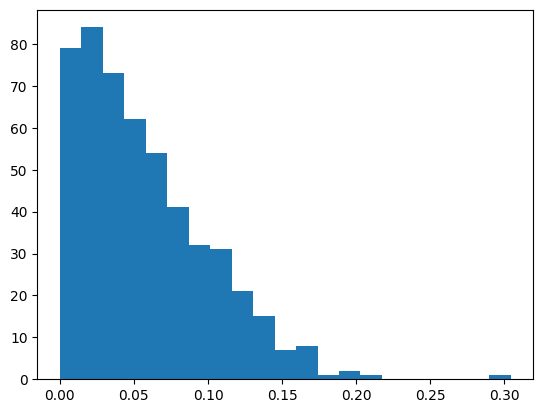

In [100]:
import matplotlib.pyplot as plt
activations_corr = np.abs(corr[0][1:])
_ = plt.hist(activations_corr, bins='auto')

In [101]:
activations_corr.shape

(512,)

In [102]:
print(activations_corr)

[2.60140866e-02 4.71640609e-02 1.12460243e-01 6.69652692e-02
 5.13776300e-02 1.68899001e-02 1.35299403e-01 1.25479295e-03
 5.36035741e-02 2.04471067e-02 2.73503617e-02 5.21144105e-02
 5.02376434e-03 3.72661625e-02 3.90067334e-02 1.02610872e-02
 1.02644675e-01 2.08552278e-02 7.63644702e-02 1.06207744e-02
 3.03762095e-02 1.37804494e-01 8.45429394e-02 4.65931058e-02
 7.54449024e-02 6.14507905e-02 1.25881468e-02 3.88364801e-02
 1.15776642e-01 2.84947434e-02 1.01955578e-02 1.05118408e-01
 6.60857362e-02 3.67126781e-02 1.90826393e-03 2.60946897e-02
 4.03961394e-02 2.41589080e-02 1.32029693e-01 1.08736115e-01
 4.58879433e-02 9.50852874e-03 9.19357152e-02 3.62515559e-02
 9.34680782e-02 8.67479239e-02 1.12783910e-01 8.70460677e-02
 6.98608441e-02 1.93326242e-01 4.60859176e-02 9.48156870e-02
 7.03047960e-02 9.55610737e-02 2.90040111e-02 2.81184008e-02
 5.90346454e-02 1.16418592e-01 1.03118840e-01 5.86732778e-02
 3.79828573e-02 4.40147376e-02 7.60360533e-02 2.89846025e-02
 1.19303373e-02 3.588502